## Setting up the API tokens and secret

Firstly, I set the API parameters for authentication provided by twitter, and search for tweets by Bill gates and Donald trump by using their twitter handle respectively. 

In [1]:
import tweepy
from tweepy import OAuthHandler
import json
import pandas as pd
from dateutil.parser import parse

 
consumer_key = 'IGu3Yt2U1t2Ft1BXJD5S5r40r'
consumer_secret = 'upxVwrxBafcHodxBqvKr4wt0AbX2rcS878kXODHUV23u7ykQSK'
access_token = '68697613-tbwR8F0lgZD4R8T8utGCguw5VUXWmwWyNAvWI4CWQ'
access_secret = 'ZEq450SB3Lbz94M2arJXr7YtUGhKkAijcOLOr1tlRh2Sb'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=False)
tweets = api.user_timeline("realDonaldTrump",count=200)
bill_tweets = api.user_timeline("BillGates",count=200)

Here I'm dumping the JSON data of tweets to a file. Twitter data is not directly JSON serializable but has a property which can be serialized, so we iterate over the statuses and dump to a JSON file.

This file contains series of json objects separated by newline character. This method does not create a json file which can be directly read into the system.

Inputs from :https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json and tweepy-user-json-prac file

In [2]:
import json
with open('bill.json', 'w') as outfile:
    for tweet in bill_tweets :
        json.dump(tweet._json, outfile)
        outfile.write('\n')

In [3]:
import json
with open('trump.json', 'w') as outfile:
    for tweet in tweets:
        json.dump(tweet._json, outfile)
        outfile.write('\n')

## Extracting required information from tweets

Here I am extracting the requird fields for analysis of the tweets and saving it to a pandas dataframe. We are interested in the following fields

- Tweet message
- created at
- retweet count
- favourite count
- source of tweet
- username

In [4]:
message,favorite_count,retweet_count,created_at,status_source,user=[],[],[],[],[],[]
for tweet in bill_tweets:
    
    message.append(tweet.text)
    favorite_count.append(tweet.favorite_count)
    retweet_count.append(tweet.retweet_count)
    created_at.append(tweet.created_at)
    status_source.append(tweet.source)
    user.append(tweet.user.name)
    
df=pd.DataFrame({'Message':message,
                'Favourite Count':favorite_count,
                'Retweet Count':retweet_count,
                'Created At':created_at,
                'Source':status_source,
                 'Username':user})
                 

In [5]:
message,favorite_count,retweet_count,created_at,status_source,user=[],[],[],[],[],[]
for tweet in tweets:
    
    message.append(tweet.text)
    favorite_count.append(tweet.favorite_count)
    retweet_count.append(tweet.retweet_count)
    created_at.append(tweet.created_at)
    status_source.append(tweet.source)
    user.append(tweet.user.name)
    
df2=pd.DataFrame({'Message':message,
                'Favourite Count':favorite_count,
                'Retweet Count':retweet_count,
                'Created At':created_at,
                'Source':status_source,
                 'Username':user})
                 


pd.concat((df,df2),axis=0).to_csv("All_tweets.csv")


## Analyzing the tweets by hour of day

Task is to compare the tweets by two users by what hour of the day it was created. So we have to parse twitter timestamp into python datetime object and get the hour from it.

In order to do this, I first coerce the timestamp column ('created at') to string since it cannot be parsed by python otherwise.

Then I proceed to pass the column through the function hour_myjob which returns hour from the string.

Finally I add all the retrieved hours as a column to the original dataframe for plotting.

In [6]:
from datetime import datetime

#This function takes a column as an input
#and iterates over the elements to parse the timestamp and returns the hour from the parsed datetime object

def hour_myjob(column):
    hour = []        #initializing a list to hold the values of all the hours
    for i in range(len(column)): #loops over the column length (twitter api sometimes gives more or less results than specified in count)
        datetimeObj = parse(column[i]) #using the parser from dateutil.parser we obtain the hour from the given timestamp
        hour.append(datetimeObj.hour) #all the results are appended and a list is returned
    

    return hour

In [7]:
df['Created At']=df['Created At'].astype(str) #coercing datatype before passing
df2['Created At']=df2['Created At'].astype(str)

In [8]:
hour_1 = hour_myjob(df['Created At']) 
hour_2 = hour_myjob(df2['Created At'])

In [9]:
df['Hour']=hour_1 #adding a new column to dataframe, which now has hour of the day for all the tweets
df2['Hour']=hour_2

In [10]:
dict_1=(df['Hour'].value_counts()/200)*100
lists=sorted(dict_1.items())  #calculating the proportion and storing results to a dictionary, this sorts the dictionary in ascending order of key

In [11]:
dict_2=(df2['Hour'].value_counts()/200)*100
lists_2=sorted(dict_2.items())

Plotting the tweets by hour

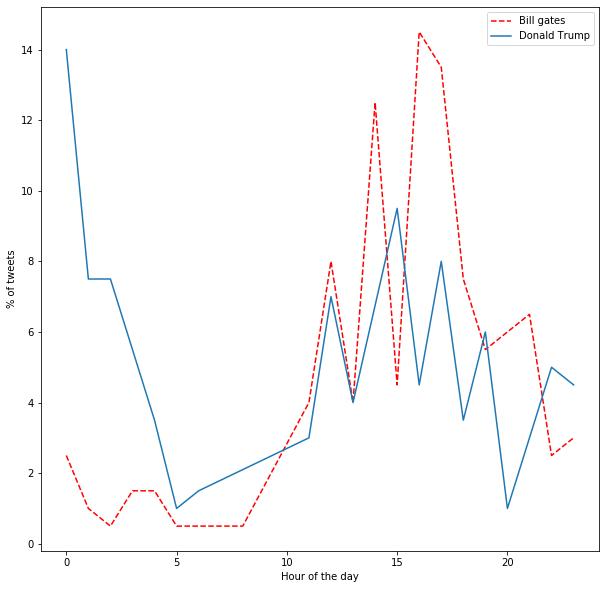

In [42]:
#This cell needs to be run twice for the figure to show

import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 

x,y = zip(*lists) #unpacking into two lists for plotting purpose
p,q = zip(*lists_2)

plt.plot(x,y,'r--',label='Bill gates')
plt.plot(p,q,label='Donald Trump')
plt.xlabel("Hour of the day")
plt.ylabel("% of tweets")
plt.legend(loc='upper right')
plt.show()

## Counting the number of links in tweets

Here we count the tweets which have a link by finding the substring "t.co" in the message. If a tweet has more than 1 link, we still take it as one for the sake of comparison (treat it like a test for presence of hyperlink instead of counting the occurences)

In [13]:
#This function takes a columnn as an input
#and finds the occurences of a substring "t.co" 

def count_links(message):
    number_of_links=[] #initializing a list to store all the results
    count=0 #this the boolean counter for checking links in tweets
    for i in range(len(message)): #interating over the lengeth of column and using string function "count" to find "t.co"
        
        count = message[i].count("t.co")
        
        if count>1: #We only need yes or no result not the actual count
            count=1
        
        number_of_links.append(count) #appending results to the list which is returned by the function
     

    return number_of_links
    

In [14]:
bill_tweets_with_link = sum(count_links(df['Message']))
bill_tweets_nolink = len(df['Message'])-bill_tweets_with_link 

print("Bill gates: Tweets with link ",bill_tweets_with_link, "| Bill gates: Tweets with no link ",bill_tweets_nolink )

Bill gates: Tweets with link  194 | Bill gates: Tweets with no link  6


In [15]:
trump_tweets_with_link = sum(count_links(df2['Message']))
trump_tweets_nolink = len(df2['Message'])-trump_tweets_with_link

print("Donald trump: Tweets with link ",trump_tweets_with_link, "| Donald trump: Tweets with no link ",trump_tweets_nolink)

Donald trump: Tweets with link  123 | Donald trump: Tweets with no link  76


## Plotting a clustered bar-graph for comparison

Here I want to visualize the results to see the difference in tweeting characteristics of the two users

Inputs from:https://matplotlib.org/examples/api/barchart_demo.html

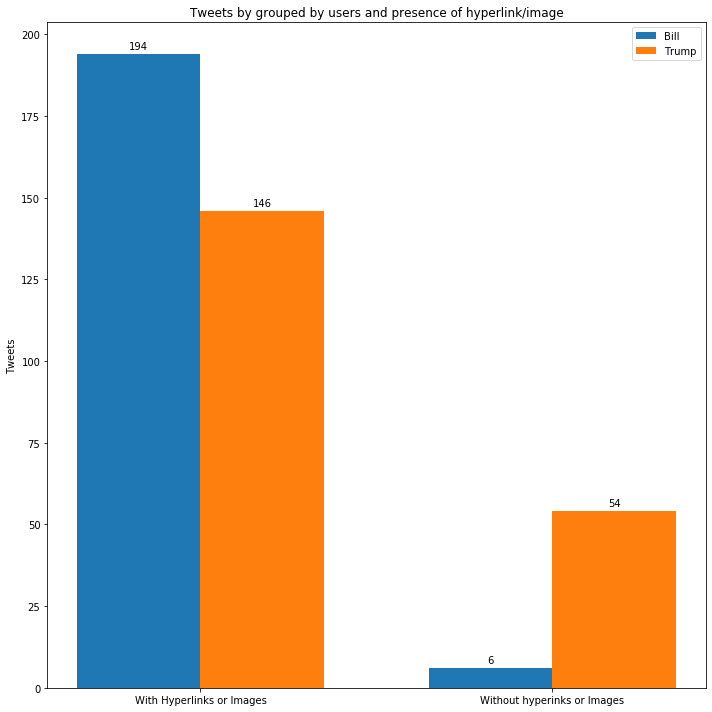

In [43]:
#This cell needs to be run twice for the figure to show

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['With Hyperlinks or Images', 'Without hyperinks or Images']
bill_list = [194,6]
trump_list = [146,54]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bill_list, width, label='Bill')
rects2 = ax.bar(x + width/2, trump_list, width, label='Trump')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tweets')
ax.set_title('Tweets by grouped by users and presence of hyperlink/image')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Looks like bill gates favours his tweets with a link, whereas Donald trump has a slightly less tedency to do so. with sizable number of tweets posted without any hyperlink we can see the difference in their tweeting pattern

## Distribution of hastags in tweets

In [17]:
df['Message']=df['Message'].astype('str')
df2['Message']=df2['Message'].astype('str')

In [18]:
#This function takes a column as an input and returns a list with counts of the hashtags in each tweet

def hash_myjob(message):
    number_of_hashtags=[] #Initializing a list to hold all the results of counts
    for i in range(len(message)): #iterating over the length of the column and using string function "count"
        
        count = message[i].count("#")
        
        number_of_hashtags.append(count) #appending the results to the list
     

    return number_of_hashtags

In [19]:
number_of_hashtags_bill = hash_myjob(df['Message'])
number_of_hashtags_trump= hash_myjob(df2['Message'])

## Plotting the histogram for hashtags: Bill gates

Text(0.5, 1.0, 'Distribution of hashtags for Bill gates')

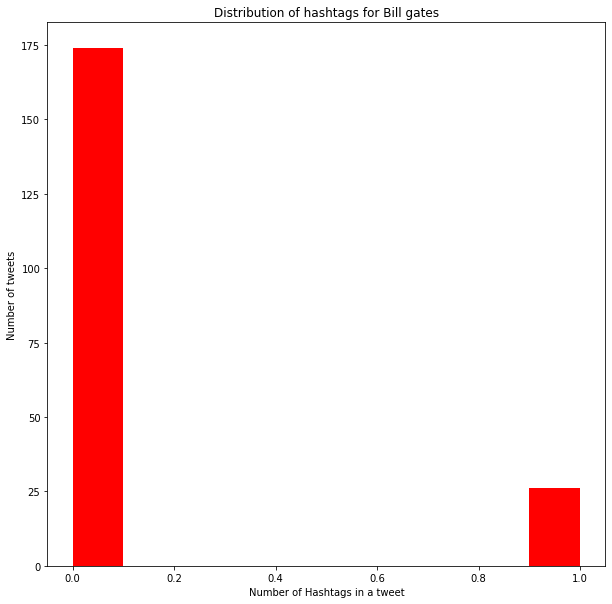

In [44]:
#This cell needs to run twice for the figure to show correctly

plt.hist(number_of_hashtags_bill,label='Bill gates',color='red')
plt.xlabel("Number of Hashtags in a tweet")
plt.ylabel("Number of tweets")
plt.title("Distribution of hashtags for Bill gates")

## Plotting the histogram of hashtags: Donald trump

Text(0.5, 1.0, 'Distribution of hashtags for Donald trump')

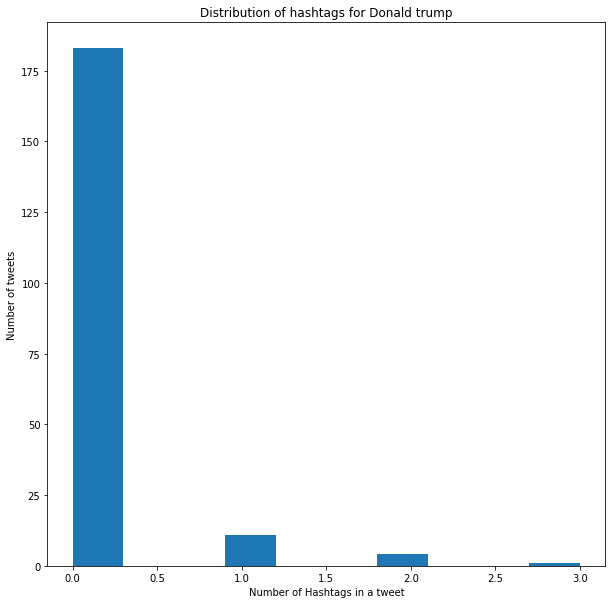

In [45]:
#This cell needs to be run twice in order to show correctly

plt.hist(number_of_hashtags_trump, label='Donald trump')
plt.xlabel("Number of Hashtags in a tweet")
plt.ylabel("Number of tweets")
plt.title("Distribution of hashtags for Donald trump")

## Logs odd ratio: Finding words most associated with user

Involved cleaning process is cleaning the tweets, removing the links, tokenizing, removing puntuation, removing stop words

In [22]:
#This function takes a column as input and returns a string
#This combines all the tweets to a string, removes all the hyperlinks

def single_sentence(column): 
    import re
    my_str = " " #Initializing the empty string to hold all the output
    for i in range(len(column)): #Iterating over the length
        my_str= my_str + column[i]
    my_str=re.sub("https://t.co/[A-Za-z\\d]+|&amp;"," ",my_str)
    return my_str

inputs from: https://machinelearningmastery.com/clean-text-machine-learning-python/

In [23]:
#This function takes a string and performs various cleaning operations
#tokenization,convert to lower case, removing punctuations, removing non alphabetic tokens, removing stopwords and then returns a list

def clean_Words(text):

    words = []
    import nltk
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    
    return words

In [24]:
text=single_sentence(df['Message'])
text_2=single_sentence(df2['Message'])

words_bill = clean_Words(text)
words_trump = clean_Words(text_2)

Dictionary of words and number of occurences

In [25]:
#This is used convert the list of clean words obtained above and get the counts for each word

from collections import Counter
a1 = Counter(words_bill)  #This returns a dictionary

a2 = Counter(words_trump)

In [26]:
a1_sorted_keys = sorted(a1, key=a1.get, reverse=True) #Sorting the dictionary by most frequently  used words
for r in a1_sorted_keys[:20]:
    print(r, a1[r])

world 30
one 25
change 21
people 19
climate 17
year 11
years 11
malaria 10
book 10
help 10
fight 10
health 9
excited 9
see 9
life 9
work 9
new 9
progress 8
need 7
globalfund 7


In [27]:
a2_sorted_keys = sorted(a2, key=a2.get, reverse=True)
for r in a2_sorted_keys[:20]:
    print(r, a2[r])

realdonaldtrump 26
schiff 24
adam 18
democrats 17
president 15
impeachment 15
pelosi 13
american 13
great 12
would 11
trump 9
inquiry 9
gopchairwoman 9
censure 8
house 8
republicans 8
thank 8
texas 8
vote 7
people 7


Calculating the logs odds ratio for both the users and printing 20 most strongly associated words with the respective user

In [28]:
odds_ratio = {} #initializing a new dictinary to hold the results
for i in a1_sorted_keys: #iterating over the keys of dictionary
    count1 = a1[i]       #getting the count for word from first user's dictionary
    
    try:
        count2=a2[i]     #Exception handling is required here because the words may not common, i.e. the second user's dictionary may not contain the same word
                         #In that case, we set the count2=0
    except:
        
        count2=0
    
    odds_ratio[i]=(np.log2((count1+1/len(words_bill)+1)/(count2+1/len(words_trump)+1))) #dividing the counts by number of all the words by that user

Words associated with Bill gates:

In [29]:
a1_sorted_keys = sorted(odds_ratio, key=odds_ratio.get, reverse=True) #Sorting the results dictionary by value
for r in a1_sorted_keys[:20]:
    print(r, odds_ratio[r])

world 4.953308489555835
change 4.458554493357952
climate 4.169056062827974
malaria 3.4585913329846507
health 3.3210951770471717
excited 3.3210951770471717
life 3.3210951770471717
progress 3.169101088655136
need 2.99918734345005
globalfund 2.99918734345005
possible 2.99918734345005
recently 2.99918734345005
commitment 2.99918734345005
incredible 2.99918734345005
alzheimer 2.99918734345005
optimistic 2.8065567376836125
really 2.8065567376836125
leadership 2.8065567376836125
remarkable 2.8065567376836125
learned 2.8065567376836125


In [30]:
count2=0 #resetting the counts as these variables were used previously
count1=0
odds_ratio_trump = {} #initializing a dictionary to hold the results
for i in a2_sorted_keys: #iterating over second user's dictionary
    count1 = a2[i] #swapped count1 value to take the number of counts from second dictionary
    
    try:
        count2=a1[i]

    
    except:
        
        count2=0
    
    odds_ratio_trump[i]=(np.log2((count1+1/len(words_trump)+1)/(count2+1/len(words_bill)+1)))

Words associated with Donald trump:

In [31]:
a2_sorted_keys = sorted(odds_ratio_trump, key=odds_ratio_trump.get, reverse=True) #sorting the results dictionary
for r in a2_sorted_keys[:20]:
    print(r, odds_ratio_trump[r])

realdonaldtrump 4.754111087829812
schiff 4.643082484279872
adam 4.247165356099204
democrats 4.169165517267736
impeachment 3.9992468645838573
pelosi 3.806609949289824
american 3.806609949289824
trump 3.3212092422839934
inquiry 3.3212092422839934
gopchairwoman 3.3212092422839934
censure 3.1692163065529457
house 3.1692163065529457
republicans 3.1692163065529457
thank 3.1692163065529457
texas 3.1692163065529457
president 2.999651945322413
vote 2.9993040021525643
congress 2.9993040021525643
party 2.8066752488141695
syria 2.8066752488141695


## Sentiment analysis

In [32]:
!pip install vaderSentiment

In [33]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [34]:
sentiment_bill=0
for sentence in df['Message']:
    vs = analyzer.polarity_scores(sentence)
    sentiment_bill=sentiment_bill+vs['compound']
    print("{:-<65} {}".format(sentence, str(vs)))

Malnutrition is the single greatest health inequity in the world. In its 2019 State of the World’s Children report,… https://t.co/G8Cm5kgeGX {'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'compound': 0.6369}
The world’s poorest people often rely on farming both to feed their families and to earn an income. They will be am… https://t.co/fZJCCR6Bhc {'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'compound': -0.5423}
Congrats to Esther Duflo, Abhijit Banerjee, and Michael Kremer for winning this year’s @NobelPrize in economics. I’… https://t.co/CF8prB94QM {'neg': 0.0, 'neu': 0.702, 'pos': 0.298, 'compound': 0.7783}
The world is facing a crisis at the dinner table, one that climate change will only worsen. I’m optimistic about th… https://t.co/HToIC1QgCa {'neg': 0.267, 'neu': 0.65, 'pos': 0.083, 'compound': -0.7269}
The odds of dying of AIDS in South Africa are less than half what they were at the peak. That progress wouldn’t hav… https://t.co/XLVdgygAa5 {'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'compou

## Average sentiment for Bill gates

In [35]:
sentiment_bill/len(df['Message'])

0.30581299999999995

In [36]:
sentiment_trump=0
for sentence in df2['Message']:
    vs = analyzer.polarity_scores(sentence)
    sentiment_trump=sentiment_trump+vs['compound']
    print("{:-<65} {}".format(sentence, str(vs)))

RT @TreasurySpox: It’s been 1️⃣ year since President @realDonaldTrump announced the new US-Mexico-Canada trade agreement. USMCA will be a w… {'neg': 0.0, 'neu': 0.849, 'pos': 0.151, 'compound': 0.4939}
RT @RepAnnWagner: As a cosponsor of the resolution to censure Rep. Adam Schiff, I was disappointed Nancy Pelosi did not even allow a vote o… {'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'compound': -0.5812}
RT @RepJohnJoyce: It is disappointing that House Democrats blocked a vote to condemn and censure Chairman Adam Schiff for lying to the Amer… {'neg': 0.386, 'neu': 0.614, 'pos': 0.0, 'compound': -0.8834}
RT @RepLaMalfa: Tonight, I joined @SteveScalise, @RepAndyBiggsAZ, &amp; @HouseGOP in voting to censure Rep. Adam Schiff. 

Of course, Democrats… {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
RT @dogoodmore: Lawmaker leading charge to censure Adam Schiff says he's engineering 'total political hit job' on Trump https://t.co/TgFQ9y… {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0

My warmest condolences to the family and many friends of Congressman Elijah Cummings. I got to see first hand the s… https://t.co/IVXZYgOkyg {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.8402}
RT @realDonaldTrump: THANK YOU, WORKING HARD! https://t.co/sNUppjB4Xm {'neg': 0.2, 'neu': 0.469, 'pos': 0.331, 'compound': 0.3382}
RT @realDonaldTrump: FAKE NEWS! https://t.co/ta8ii8yetP---------- {'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.628}
RT @realDonaldTrump: Nancy Pelosi needs help fast! There is either something wrong with her “upstairs,” or she just plain doesn’t like our… {'neg': 0.112, 'neu': 0.689, 'pos': 0.199, 'compound': 0.3382}
This is the real story. Thank you Jim! https://t.co/VqJrsUJdiX--- {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.4199}
RT @senatemajldr: Washington Democrats have been engaged in a three-year-long impeachment parade in search of a rationale. Prominent House… {'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compound': 0.6124}
RT @senatem

## Average sentiment for Donald trump

In [37]:
sentiment_trump/len(df2['Message'])

0.06802110552763818

We see Trump's sentiment is quite negative as compared to Bill gates

In [38]:
combined_sentiment=(sentiment_bill/200+sentiment_trump/200)/2
print(combined_sentiment)

0.18674699999999997
